# points

> binomial and poisson point process

In [ ]:
#| hide
#| default_exp points

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from scipy.spatial import ConvexHull
import functools
import collections
from typing import Literal, Optional
from fastcore.basics import patch

In [ ]:
#|export

def in_hull(point:np.array,  # 1d array 
            hull:ConvexHull, # see scipy.spatial
            tol=1e-9): 
    """checks whether point is inside hull"""
    assert len(point)==hull.ndim, "expect point, hull in the same dimension"
    W,b = hull.equations[:,:-1], hull.equations[:,-1]
    return np.all(W@point+b<=tol)

In [ ]:
#|export
class Points:
    """define binomial or poisson point process in a convex polytope"""
    def __init__(self, n:int, # (expected) number of points 
                d=2,  # dimensionality
                seed:Optional[int]=None, 
                law: Literal["binomial","poisson"]="binomial", # distribution of the points 
                shape:Optional[ConvexHull]=None): # sample from shape, default to unit box
        assert law in ["binomial","poisson"]
        self.rng = np.random.default_rng(seed)
        self.n = rng.poisson(n) if law == "poisson" else n
        self.d = d
        self.shape = shape


In [ ]:
#|export
@patch
def points(self:Points):
    """actually generate points from the prescribed distribution"""
    if self.shape is None: # unit cube
        return self.rng.uniform(size=(self.n,self.d))
    else:
        ps = []
        for _ in range(self.n):
            while True:
                # mint new point, cannot pass seed
                sample = np.random.default_rng().uniform(self.shape.min_bound, self.shape.max_bound,(self.d,))                     
                if in_hull(sample, self.shape): ps.append(sample); break
        assert len(ps)==self.n
        return np.array(ps)

In [ ]:
import matplotlib.pyplot as plt

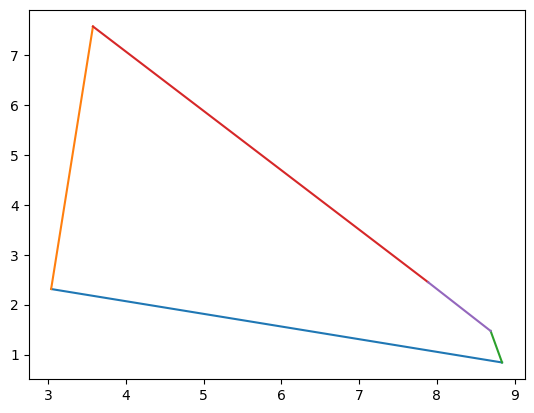

In [ ]:
rng = np.random.default_rng()
vertices = rng.uniform(0,10,size=(5,2))
hull = ConvexHull(vertices)
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

False


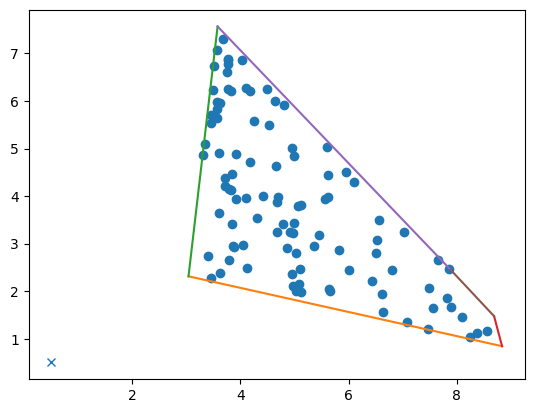

In [ ]:

bin = Points(100,shape=hull).points()
p = np.array([0.5,0.5])
print(in_hull(p, hull))
plt.scatter(*bin.T)
plt.plot(*p, 'x')
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

In [ ]:
Points(5,d=3,shape=ConvexHull(np.random.default_rng().uniform(size=(4,3)))).points()

array([[0.55929895, 0.3224529 , 0.62387364],
       [0.45143895, 0.26383372, 0.84811532],
       [0.56043386, 0.36140855, 0.69203657],
       [0.57713033, 0.34318832, 0.61329044],
       [0.78998039, 0.57005614, 0.38483107]])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()